# 使用 JAX 和 Flax 实现 S4

注意：本项目使用 JAX 结合 Flax 神经网络库。虽然我们个人主要使用 Torch，但 JAX 的函数式特性非常适合处理 S4 的一些复杂性。我们大量使用 vmap、scan、它们的神经网络对应函数，以及最重要的 jax.jit 来编译高效的 S4 层。

In [2]:
from functools import partial
import jax
import jax.numpy as np
from flax import linen as nn
from jax.nn.initializers import lecun_normal, normal
from jax.numpy.linalg import eigh, inv, matrix_power
from jax.scipy.signal import convolve

In [3]:
if __name__ == "__main__":
    # For this tutorial, construct a global JAX rng key
    # But we don't want it when importing as a library
    rng = jax.random.PRNGKey(1)

让我们开始吧！我们的目标是对长序列进行高效建模。为此，我们将基于状态空间模型 (SSM) 构建一个新的神经网络层。在本节结束时，我们将能够构建并运行包含该层的模型。但首先，我们需要一些技术背景。

状态空间模型由以下简单方程定义，它将一维输入信号 $u(t)$ 映射到 $N$ 维潜在状态 $x(t)$，然后投影到一维输出信号 $y(t)$：
\begin{align}
x'(t) &= A x(t) + B u(t) \\
y(t) &= C x(t) + D u(t)
\end{align}

我们的目标是将 SSM 简单地作为深度序列模型中的黑盒表示，其中 $A, B, C, D$ 是通过梯度下降学习的参数。为了简化，后续我们将忽略参数 $D$（或者假设 $D = 0$，因为 $D u$ 可视为跳跃连接，计算简单）。

SSM 将输入 $u(t)$ 映射到状态表示向量 $x(t)$ 和输出 $y(t)$。为了简单起见，假设输入和输出是一维的，而状态表示是 $N$ 维的。第一个方程定义了 $x(t)$ 随时间的变化。

# 定义随机 SSM

我们的 SSM 由三个矩阵 $A, B, C$ 定义，它们将被学习。我们先从一个随机 SSM 开始以定义尺寸：

In [4]:
def random_SSM(rng, N):
    a_r, b_r, c_r = jax.random.split(rng, 3)
    A = jax.random.uniform(a_r, (N, N))
    B = jax.random.uniform(b_r, (N, 1))
    C = jax.random.uniform(c_r, (1, N))
    return A, B, C
def discretize(A, B, C, step):
    I = np.eye(A.shape[0])
    BL = inv(I - (step / 2.0) * A)
    Ab = BL @ (I + (step / 2.0) * A)
    Bb = (BL * step) @ B
    return Ab, Bb, C

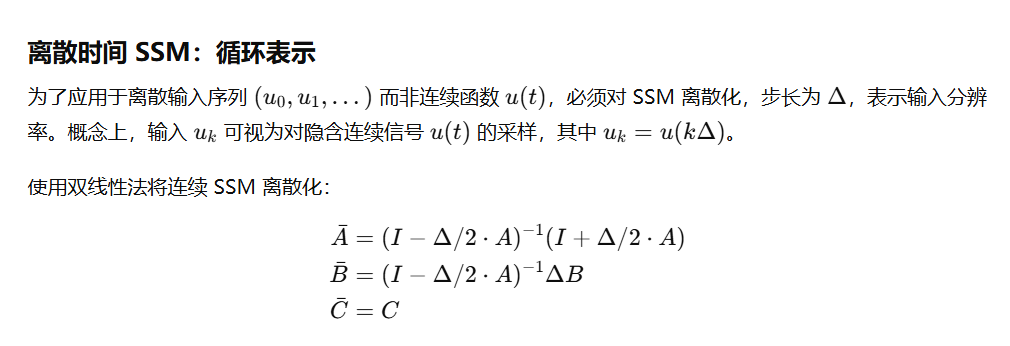

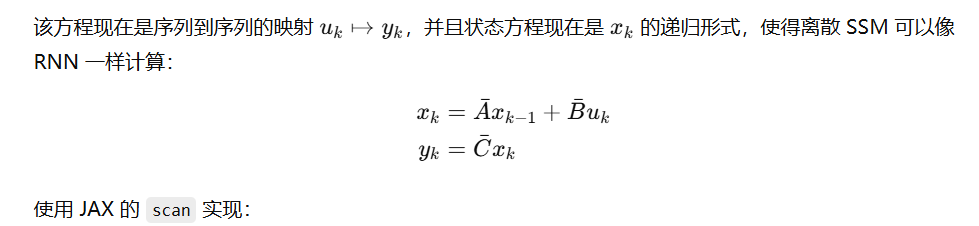

In [5]:
def scan_SSM(Ab, Bb, Cb, u, x0):
    def step(x_k_1, u_k):
        x_k = Ab @ x_k_1 + Bb @ u_k
        y_k = Cb @ x_k
        return x_k, y_k

    return jax.lax.scan(step, x0, u)

In [6]:
def run_SSM(A, B, C, u):
    L = u.shape[0]
    N = A.shape[0]
    Ab, Bb, Cb = discretize(A, B, C, step=1.0 / L)

    # Run recurrence
    return scan_SSM(Ab, Bb, Cb, u[:, np.newaxis], np.zeros((N,)))[1]

In [7]:
def example_mass(k, b, m):
    A = np.array([[0, 1], [-k / m, -b / m]])
    B = np.array([[0], [1.0 / m]])
    C = np.array([[1.0, 0]])
    return A, B, C

In [8]:
@partial(np.vectorize, signature="()->()")
def example_force(t):
    x = np.sin(10 * t)
    return x * (x > 0.5)

In [9]:
def example_ssm():
    # SSM
    ssm = example_mass(k=40, b=5, m=1)

    # L samples of u(t).
    L = 100
    step = 1.0 / L
    ks = np.arange(L)
    u = example_force(ks * step)

    # Approximation of y(t).
    y = run_SSM(*ssm, u)

    # Plotting ---
    import matplotlib.pyplot as plt
    import seaborn
    from celluloid import Camera

    seaborn.set_context("paper")
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    camera = Camera(fig)
    ax1.set_title("Force $u_k$")
    ax2.set_title("Position $y_k$")
    ax3.set_title("Object")
    ax1.set_xticks([], [])
    ax2.set_xticks([], [])

    # Animate plot over time
    for k in range(0, L, 2):
        ax1.plot(ks[:k], u[:k], color="red")
        ax2.plot(ks[:k], y[:k], color="blue")
        ax3.boxplot(
            [[y[k, 0] - 0.04, y[k, 0], y[k, 0] + 0.04]],
            showcaps=False,
            whis=False,
            vert=False,
            widths=10,
        )
        camera.snap()
    anim = camera.animate()
    anim.save("line.gif", dpi=150, writer="imagemagick")


MovieWriter imagemagick unavailable; using Pillow instead.


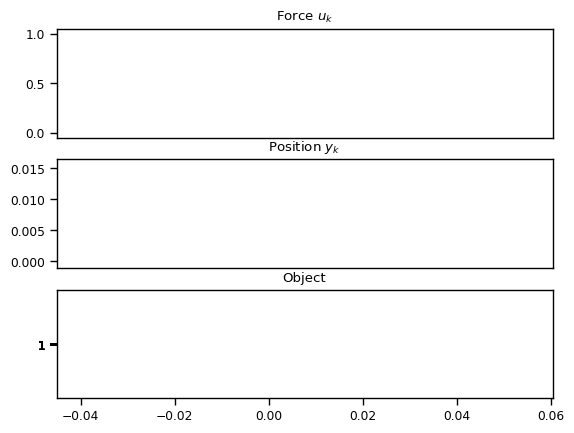

In [10]:
example_ssm()

## 训练 SSM：卷积表示（Training SSMs: The Convolutional Representation）

本节的核心结论（punchline）是：我们可以通过展开（unrolling）将上面的“RNN”形式的状态空间模型（SSM）转化为“CNN”。  
下面我们将逐步推导这一结论。

传统的递归 SSM 在现代硬件上训练效率较低，因为它具有显著的序列依赖性。然而，在线性时不变（LTI, Linear Time-Invariant）系统中，存在一个重要联系：SSM 可以等价地表示为一个连续卷积（continuous convolution）。  
相应地，离散形式的递归 SSM 也可以被写作一个{离散卷积（discrete convolution）。

为简化推导，设初始状态为：
\[
x_{-1} = 0
\]

则展开计算得到：
\[
\begin{aligned}
x_0 &= \bar{B}u_0 \\
x_1 &= \bar{A}\bar{B}u_0 + \bar{B}u_1 \\
x_2 &= \bar{A}^2\bar{B}u_0 + \bar{A}\bar{B}u_1 + \bar{B}u_2 \\
\vdots \\
y_0 &= \bar{C}\bar{B}u_0 \\
y_1 &= \bar{C}\bar{A}\bar{B}u_0 + \bar{C}\bar{B}u_1 \\
y_2 &= \bar{C}\bar{A}^2\bar{B}u_0 + \bar{C}\bar{A}\bar{B}u_1 + \bar{C}\bar{B}u_2 \\
\vdots
\end{aligned}
\]

可以看到每一步的输出 $y_k$ 都由输入序列 $\{u_0, u_1, \dots, u_k\}$ 的加权和构成，而加权系数取决于 $\bar{A}$、$\bar{B}$ 和 $\bar{C}$ 的幂次关系。  
这种结构可以进一步\textbf{向量化（vectorize）}为卷积形式：

$y_k = \bar{C}\bar{A}^k\bar{B}u_0 + \bar{C}\bar{A}^{k-1}\bar{B}u_1 + \cdots + \bar{C}\bar{A}\bar{B}u_{k-1} + \bar{C}\bar{B}u_k$

即：
$y = \bar{K} * u$

其中：
$
\bar{K} \in \mathbb{R}^L = (\bar{C}\bar{B}, \bar{C}\bar{A}\bar{B}, \dots, \bar{C}\bar{A}^{L-1}\bar{B})
$

我们将 $\bar{K}$ 称为SSM 卷积核（SSM convolution kernel） 或滤波器（filter）。

需要注意的是，这个卷积核 $\bar{K}$ 的长度与整个序列长度 $L$ 相同，因此它是一个\textbf{巨大的滤波器}（giant filter），其参数量与序列长度成正比。


In [22]:
def K_conv(Ab, Bb, Cb, L):
    return np.array(
        [(Cb @ matrix_power(Ab, l) @ Bb).reshape() for l in range(L)]
    )
def causal_convolution(u, K, nofft=False):
    if nofft:
        return convolve(u, K, mode="full")[: u.shape[0]]
    else:
        assert K.shape[0] == u.shape[0]
        ud = np.fft.rfft(np.pad(u, (0, K.shape[0])))
        Kd = np.fft.rfft(np.pad(K, (0, u.shape[0])))
        out = ud * Kd
        return np.fft.irfft(out)[: u.shape[0]]
def test_cnn_is_rnn(N=4, L=16, step=1.0 / 16):
    ssm = random_SSM(rng, N)
    u = jax.random.uniform(rng, (L,))
    jax.random.split(rng, 3)
    # RNN
    rec = run_SSM(*ssm, u)

    # CNN
    ssmb = discretize(*ssm, step=step)
    conv = causal_convolution(u, K_conv(*ssmb, L))

    # Check
    assert np.allclose(rec.ravel(), conv.ravel())

In [23]:
def log_step_initializer(dt_min=0.001, dt_max=0.1):
    def init(key, shape):
        return jax.random.uniform(key, shape) * (
            np.log(dt_max) - np.log(dt_min)
        ) + np.log(dt_min)

    return init

In [24]:
class SSMLayer(nn.Module):
    N: int
    l_max: int
    decode: bool = False

    def setup(self):
        # SSM parameters
        self.A = self.param("A", lecun_normal(), (self.N, self.N))
        self.B = self.param("B", lecun_normal(), (self.N, 1))
        self.C = self.param("C", lecun_normal(), (1, self.N))
        self.D = self.param("D", nn.initializers.ones, (1,))

        # Step parameter
        self.log_step = self.param("log_step", log_step_initializer(), (1,))

        step = np.exp(self.log_step)
        self.ssm = discretize(self.A, self.B, self.C, step=step)
        self.K = K_conv(*self.ssm, self.l_max)

        # RNN cache for long sequences
        self.x_k_1 = self.variable("cache", "cache_x_k", np.zeros, (self.N,))

    def __call__(self, u):
        if not self.decode:
            # CNN Mode
            return causal_convolution(u, self.K) + self.D * u
        else:
            # RNN Mode
            x_k, y_s = scan_SSM(*self.ssm, u[:, np.newaxis], self.x_k_1.value)
            if self.is_mutable_collection("cache"):
                self.x_k_1.value = x_k
            return y_s.reshape(-1).real + self.D * u

In [25]:
def cloneLayer(layer):
    return nn.vmap(
        layer,
        in_axes=1,
        out_axes=1,
        variable_axes={"params": 1, "cache": 1, "prime": 1},
        split_rngs={"params": True},
    )
SSMLayer = cloneLayer(SSMLayer)

In [5]:
import jax
import jax.numpy as jnp
from jax import random, lax

# =========================
# 1️⃣ 初始化参数
# =========================
def init_ssm_params(key, hidden_dim, input_dim, output_dim):
    k1, k2, k3 = random.split(key, 3)
    A = random.normal(k1, (hidden_dim, hidden_dim)) * 0.1
    B = random.normal(k2, (hidden_dim, input_dim)) * 0.1
    C = random.normal(k3, (output_dim, hidden_dim)) * 0.1
    return {"A": A, "B": B, "C": C}


# =========================
# 2️⃣ 状态更新函数 (Mamba公式)
# =========================
def mamba_step(params, x_t, u_t, delta=1.0):
    """
    实现离散化后的 Mamba SSM 公式:
        x_{t+1} = e^{ΔA} x_t + (ΔB) u_t
        y_t = C x_t
    """
    # 连续 -> 离散
    A_bar = jnp.exp(delta * params["A"])   # e^{ΔA}
    B_bar = delta * params["B"]

    # 状态更新
    x_next = A_bar @ x_t + B_bar @ u_t
    y_t = params["C"] @ x_t
    return x_next, y_t


# =========================
# 3️⃣ 整个序列传播 (lax.scan)
# =========================
def mamba_forward(params, inputs):
    """
    inputs: [T, input_dim]
    返回 y 序列: [T, output_dim]
    """
    init_state = jnp.zeros((params["A"].shape[0],))

    def step(carry, u_t):
        x_t = carry
        x_next, y_t = mamba_step(params, x_t, u_t)
        return x_next, y_t

    _, ys = lax.scan(step, init_state, inputs)
    return ys


# =========================
# 4️⃣ 测试公式运行
# =========================
if __name__ == "__main__":
    key = random.PRNGKey(0)
    hidden_dim = 4
    input_dim = 1
    output_dim = 1

    params = init_ssm_params(key, hidden_dim, input_dim, output_dim)

    # 输入一个简单的信号序列
    T = 10
    t = jnp.linspace(0, 2*jnp.pi, T)
    u = jnp.sin(t).reshape(T, 1)

    y = mamba_forward(params, u)

    print("输入 u:", u.squeeze())
    print("输出 y:", y.squeeze())




输入 u: [ 0.0000000e+00  6.4278764e-01  9.8480779e-01  8.6602539e-01
  3.4202000e-01 -3.4202039e-01 -8.6602545e-01 -9.8480767e-01
 -6.4278740e-01  1.7484555e-07]
输出 y: [ 0.0000000e+00  0.0000000e+00 -3.6858693e-02 -1.0036287e-01
 -2.7973449e-01 -9.7097516e-01 -3.7527585e+00 -1.4855441e+01
 -5.8908302e+01 -2.3339355e+02]
